# Classification of fixed size paragraph vectors using LSTM
should be able to deal with all levels using the PARTS_LEVEL param

In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline




import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import multiprocessing
from multiprocessing import Process, Queue

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.convolutional import MaxPooling1D, Convolution1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *
from thesis.utils.file import *

Using Theano backend.
Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Global variables used throughout the script

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
QUEUE_SIZE = 50

In [5]:
NUM_CORES = 16

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"
TEST_DATA_MATRIX = "Xt_level_{}.npy"
TEST_LABELS_MATRIX = "yt_{}.npy"

TRAINING_DATA_MATRIX_PART = "X_level_{}-{}.npy"
TRAINING_LABELS_MATRIX_PART = "y_{}-{}.npy"

In [8]:
NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [9]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

matrices_save_location = big_data_location + "extended_pv_matrices/"
# matrices_save_location = big_data_location + "extended_pv_matrices/one_model/"
exports_location = root_location + "exported_data/"

nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_full_chunks")

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

# Load general data required for classification

In [10]:
%%time
sections = pickle.load(open(sections_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 2.06 s, sys: 184 ms, total: 2.24 s
Wall time: 2.24 s


In [11]:
len(training_docs_list)

1286325

In [12]:
len(validation_docs_list)

321473

In [13]:
len(test_docs_list)

401877

# Utility Functions for data loading

In [14]:
data_type_file_dict ={
    "training": TRAINING_DATA_MATRIX,
    "validation": VALIDATION_DATA_MATRIX,
    "test": TEST_DATA_MATRIX,
}
labels_type_file_dict ={
    "training": TRAINING_LABELS_MATRIX,
    "validation": VALIDATION_LABELS_MATRIX,
    "test": TEST_LABELS_MATRIX,
}

def get_data_dirs(classifications_type, level, data_type):
    data_dir = os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                data_type_file_dict[data_type].format(level))
    labels_dir = os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                labels_type_file_dict[data_type].format(classifications_type))
    return data_dir, labels_dir

def get_data(data_file, labels_file, mmap=False):
    mmap_mode = None
    if mmap == True:
        mmap_mode = "r"
    X_data = np.load(data_file, mmap_mode=mmap_mode)
    y_data = np.load(labels_file, mmap_mode=mmap_mode)
    return X_data, y_data

In [15]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                Xv_file, yv_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'validation')
                Xv, yv = get_data(Xv_file, yv_file, mmap=True)
                yvp = self.model.predict_generator(generator=batch_generator(Xv_file, yv_file, NN_BATCH_SIZE, is_mlp=False, validate=True),\
                                       max_q_size=QUEUE_SIZE,\
                                       val_samples=len(validation_docs_list))
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [16]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None, conv_filter_length=3, max_pooling_length=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=conv_filter_length, 
                                border_mode='same', activation='relu'))
        if max_pooling_length is not None:
            model.add(MaxPooling1D(pool_length=max_pooling_length))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_w-drop_{}_u-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model

In [17]:
class ArrayReader(Process):
    def __init__(self, input_file, label_file, out_queue, batch_size, is_mlp=False, validate=False):
        super(ArrayReader, self).__init__()
        self.is_mlp = is_mlp
        self.validate = validate
        self.q = out_queue
        self.batch_size = batch_size
        self.input_file = input_file
        self.label_file = label_file

    def run(self):
        x_file = np.load(self.input_file, mmap_mode='r')
        y_file = np.load(self.label_file, mmap_mode='r')
        start_item = 0
        num_iter = 0
#         shuffled_indices = np.arange(y_file.shape[0])
#         np.random.shuffle(shuffled_indices)
        while True:
            if start_item > y_file.shape[0]:
                info('in new epoch for {}'.format(os.path.basename(self.input_file)))
#                 np.random.seed(42 + num_iter)
#                 np.random.shuffle(shuffled_indices)
                start_item = 0
#             start_time = time.time()
            x_file[0:200000]
#             y_batch = np.copy(y_file[start_item: start_item + self.batch_size])
#             x_batch = np.copy(x_file[start_item: start_item + self.batch_size])
            y_batch = y_file[start_item: start_item + self.batch_size]
            x_batch = x_file[start_item: start_item + self.batch_size]
#             batch_indices = shuffled_indices[start_item: start_item + self.batch_size]
#             x_batch = x_file[batch_indices]
#             y_batch = y_file[batch_indices]
#             print 'Duration: {}'.format(str(time.time() - start_time))
            # because we use MLP
            if self.is_mlp:
                x_batch = np.reshape(x_batch, (x_batch.shape[0], x_batch.shape[1] * x_batch.shape[2]))
            start_item += self.batch_size
            num_iter += 1
            try:
                #print 'adding new batch'
                self.q.put((x_batch, y_batch), block=True)
            except:
                return

            
def batch_generator(input_file, label_file, batch_size, is_mlp=False, validate=False):
    q = Queue(maxsize=QUEUE_SIZE)
    p = ArrayReader(input_file, label_file, q, batch_size, is_mlp, validate)
    p.start()
    while True:
        item = q.get()
        if not item:
            p.terminate()
            raise StopIteration()
        else:
            yield item

# Global Param Loop

In [18]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.3},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [19]:
LEVEL_DOC = 1
LEVEL_DIVISIONS = 2
LEVEL_CHUNKS = 3

In [20]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_EPOCH = 8

In [21]:
GLOBAL_PARMS_TO_RUN = [
    {
        'doc2vec_epoch': DOC2VEC_EPOCH,
        'classifications': valid_subclasses,
        'classifications_type': 'subclasses',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 2048,
        'lstm_output_size': 1000,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 1,
        'lstm_conv_size': None,
        'lstm_conv_filter_length': None,
        'lstm_max_pooling_length': None
    }
]


==================================== NEW PARAM SET ============================================
{'lstm_conv_filter_length': None, 'lstm_stack_layers': 1, 'nn_batch_size': 2048, 'classifications_type': 'subclasses', 'lstm_w_dropout': 0.5, 'lstm_max_pooling_length': None, 'lstm_u_dropout': 0.5, 'parts_level': 2, 'lstm_output_size': 1000, 'doc2vec_epoch': 8, 'lstm_conv_size': None}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-16 03:12:37,105 : INFO : No Previous results exist in /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_subclasses_level_2_batch_2048_nn_parameter_searches.pkl
2017-04-16 03:12:37,105 : INFO : ***************************************************************************************
2017-04-16 03:12:37,106 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          4804000     lstm_input_1[0][0]               
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 940)           940940      lstm_1000_w-drop_0.5_u-drop_0.5_l
Total params: 5,744,940
Trainable params: 5,744,940
Non-trainable params: 0
____________________________________________________________________________________________________


<IPython.core.display.Javascript object>


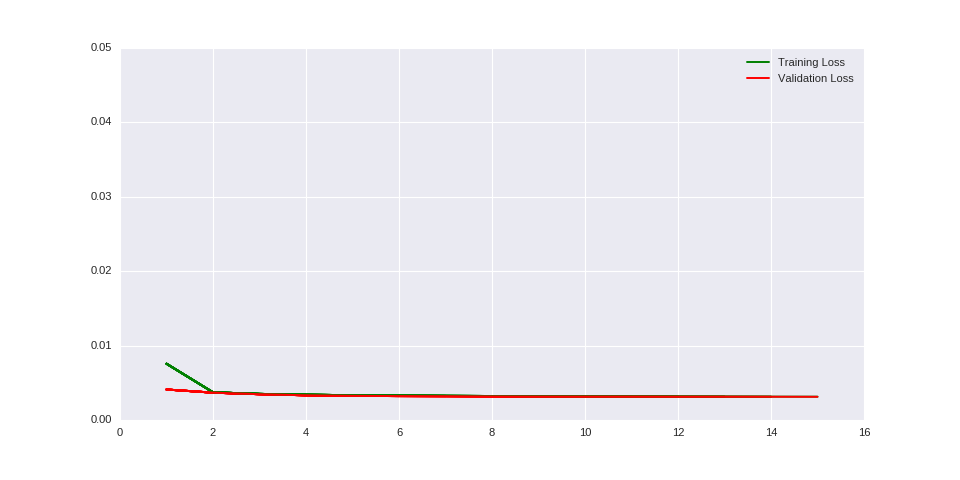

Epoch 1/200
1081344/1286325 [========================>.....] - ETA: 37s - loss: 0.0082

2017-04-16 03:16:15,967 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0076

2017-04-16 03:17:00,764 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:17:13,441 : INFO : Found lower val loss for epoch 1 => 0.0041


    
1286325/1286325 [==============================] - 256s - loss: 0.0076 - val_loss: 0.0041
Epoch 2/200
1081344/1286325 [========================>.....] - ETA: 40s - loss: 0.0037

2017-04-16 03:20:44,907 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-16 03:21:27,114 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:21:46,753 : INFO : Found lower val loss for epoch 2 => 0.00367


    
1286325/1286325 [==============================] - 273s - loss: 0.0037 - val_loss: 0.0037
Epoch 3/200
1081344/1286325 [========================>.....] - ETA: 39s - loss: 0.0035

2017-04-16 03:25:16,566 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0035

2017-04-16 03:25:55,726 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:26:10,251 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:26:16,420 : INFO : Found lower val loss for epoch 3 => 0.00347


    
1286325/1286325 [==============================] - 269s - loss: 0.0035 - val_loss: 0.0035
Epoch 4/200
1081344/1286325 [========================>.....] - ETA: 39s - loss: 0.0034

2017-04-16 03:29:47,389 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0034

2017-04-16 03:30:35,654 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:30:49,201 : INFO : Found lower val loss for epoch 4 => 0.00332


    
1286325/1286325 [==============================] - 272s - loss: 0.0034 - val_loss: 0.0033
Epoch 5/200
1081344/1286325 [========================>.....] - ETA: 40s - loss: 0.0033

2017-04-16 03:34:20,416 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-16 03:35:02,872 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:35:21,900 : INFO : Found lower val loss for epoch 5 => 0.00324


    
1286325/1286325 [==============================] - 272s - loss: 0.0033 - val_loss: 0.0032
Epoch 6/200
1081344/1286325 [========================>.....] - ETA: 39s - loss: 0.0033

2017-04-16 03:38:52,732 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-16 03:39:33,125 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:39:50,328 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:39:55,826 : INFO : Found lower val loss for epoch 6 => 0.00321


    
1286325/1286325 [==============================] - 273s - loss: 0.0033 - val_loss: 0.0032
Epoch 7/200
1081344/1286325 [========================>.....] - ETA: 38s - loss: 0.0033

2017-04-16 03:43:20,761 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0033

2017-04-16 03:44:08,756 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:44:19,183 : INFO : Found lower val loss for epoch 7 => 0.0032


    
1286325/1286325 [==============================] - 263s - loss: 0.0033 - val_loss: 0.0032
Epoch 8/200
1081344/1286325 [========================>.....] - ETA: 39s - loss: 0.0032

2017-04-16 03:47:47,512 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-16 03:48:29,439 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:48:49,280 : INFO : Found lower val loss for epoch 8 => 0.00316


    
1286325/1286325 [==============================] - 270s - loss: 0.0032 - val_loss: 0.0032
Epoch 9/200
1081344/1286325 [========================>.....] - ETA: 39s - loss: 0.0032

2017-04-16 03:52:18,197 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-16 03:52:57,781 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:53:15,072 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:53:19,539 : INFO : Found lower val loss for epoch 9 => 0.00315


    
1286325/1286325 [==============================] - 270s - loss: 0.0032 - val_loss: 0.0031
Epoch 10/200
1081344/1286325 [========================>.....] - ETA: 38s - loss: 0.0032

2017-04-16 03:56:45,021 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-16 03:57:33,983 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 03:57:44,625 : INFO : Found lower val loss for epoch 10 => 0.00314


    
1286325/1286325 [==============================] - 265s - loss: 0.0032 - val_loss: 0.0031
Epoch 11/200
1081344/1286325 [========================>.....] - ETA: 39s - loss: 0.0032

2017-04-16 04:01:11,221 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-16 04:01:54,934 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 04:02:13,824 : INFO : Found lower val loss for epoch 11 => 0.00314


    
1286325/1286325 [==============================] - 269s - loss: 0.0032 - val_loss: 0.0031
Epoch 12/200
1081344/1286325 [========================>.....] - ETA: 38s - loss: 0.0032

2017-04-16 04:05:39,006 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-16 04:06:18,754 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 04:06:37,977 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 04:06:41,470 : INFO : Found lower val loss for epoch 12 => 0.00313


    
1286325/1286325 [==============================] - 267s - loss: 0.0032 - val_loss: 0.0031
Epoch 13/200
1081344/1286325 [========================>.....] - ETA: 38s - loss: 0.0032

2017-04-16 04:10:06,620 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0032

2017-04-16 04:10:56,506 : INFO : in new epoch for Xv_level_2.npy


1286325/1286325 [==============================] - 266s - loss: 0.0032 - val_loss: 0.0031
Epoch 14/200
1081344/1286325 [========================>.....] - ETA: 39s - loss: 0.0031

2017-04-16 04:14:34,446 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0031

2017-04-16 04:15:18,147 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 04:15:33,349 : INFO : Found lower val loss for epoch 14 => 0.00312


    
1286325/1286325 [==============================] - 265s - loss: 0.0031 - val_loss: 0.0031
Epoch 15/200
1081344/1286325 [========================>.....] - ETA: 38s - loss: 0.0031

2017-04-16 04:18:58,854 : INFO : in new epoch for X_level_2.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0031

2017-04-16 04:19:38,429 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 04:19:54,856 : INFO : in new epoch for Xv_level_2.npy
2017-04-16 04:19:56,948 : INFO : Found lower val loss for epoch 15 => 0.00312


    
1286325/1286325 [==============================] - 263s - loss: 0.0031 - val_loss: 0.0031
Epoch 16/200
 294912/1286325 [=====>........................] - ETA: 191s - loss: 0.0031

In [ ]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    classifier_file = TYPE_CLASSIFIER.format(classifications_type)
    
    PARTS_LEVEL = GLOBAL_PARAMS['parts_level']
    
    
    placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

    epoch = GLOBAL_PARAMS['doc2vec_epoch']

    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    print GLOBAL_VARS.MODEL_NAME
    
    time.sleep(0.2)
    
    
    X_file, y_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'training')
    Xv_file, yv_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'validation')
    X, y = get_data(X_file, y_file, mmap=True)
    
    
#     info("Loading Validation Documents")
#     Xv, yv = get_validation_data(classifications_type, PARTS_LEVEL)
#     print Xv.shape
#     print yv.shape
    
    NN_INPUT_NEURONS = DOC2VEC_SIZE
    NN_OUTPUT_NEURONS = len(classifications)
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 2

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    np.random.seed(NN_SEED)
    
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}
    
    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
        
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    start_time = time.time()
    lstm_output_size = GLOBAL_PARAMS['lstm_output_size']
    w_dropout_do = GLOBAL_PARAMS['lstm_w_dropout']
    u_dropout_do = GLOBAL_PARAMS['lstm_u_dropout']
    stack_layers = GLOBAL_PARAMS['lstm_stack_layers']
    conv_size = GLOBAL_PARAMS['lstm_conv_size']
    conv_filter_length = GLOBAL_PARAMS['lstm_conv_filter_length']
    conv_max_pooling_length = GLOBAL_PARAMS['lstm_max_pooling_length']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )
    if conv_size:
        GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                         conv_max_pooling_length)

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                                   conv_filter_length, conv_max_pooling_length)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()


    # Model Fitting
    %time history = model.fit_generator(generator=batch_generator(X_file, y_file, NN_BATCH_SIZE, is_mlp=False, validate=False),\
                                        validation_data=batch_generator(Xv_file, yv_file, NN_BATCH_SIZE, is_mlp=False, validate=True),\
                                        samples_per_epoch=len(training_docs_list), \
                                        nb_val_samples=len(validation_docs_list),\
                                        nb_epoch=NN_MAX_EPOCHS,\
                                        callbacks=[early_stopper, metrics_callback],\
                                        max_q_size=QUEUE_SIZE)
                                        #validation_data=(Xv,yv), 
                                        
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict_generator(generator=batch_generator(Xv_file, yv_file, NN_BATCH_SIZE, is_mlp=False, validate=True),\
                                       max_q_size=QUEUE_SIZE,\
                                       val_samples=len(validation_docs_list))
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    Xv, yv = get_data(Xv_file, yv_file, mmap=True)
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

#     del history, metrics_callback, model

    for p in multiprocessing.active_children():
        # closing the array readers
        p.terminate()

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(param_results_path, 'w'))
        

In [24]:
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])

****** Validation Metrics: Cov Err: 5.665 | Top 3: 0.783 | Top 5: 0.859 | F1 Micro: 0.605 | F1 Macro: 0.224


In [25]:
param_results_path

'/mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_subclasses_level_2_batch_2048_nn_parameter_searches.pkl'

In [26]:
pickle.dump(param_results_dict, open(param_results_path, 'w'))

In [23]:
param_results_dict

{'lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None': {'best_val_loss': 0.0030526203505566421,
  'best_validation_metrics': {'average_num_of_labels': 1.34,
   'coverage_error': 5.6654026932277359,
   'f1_macro': 0.22392186142137971,
   'f1_micro': 0.60491305431418607,
   'precision_macro': 0.3169606426027462,
   'precision_micro': 0.7028962634493453,
   'recall_macro': 0.19111652844971222,
   'recall_micro': 0.5309052612087124,
   'top_1': 0.6433881906349096,
   'top_3': 0.7831377450640001,
   'top_5': 0.8589704418674629,
   'total_positive': 326317},
  'best_weights': [array([[-0.09070328,  0.06139495, -0.08611846, ...,  0.18072763,
           -0.06601099, -0.06330364],
          [ 0.05953017,  0.12531984, -0.07563997, ...,  0.14196774,
            0.07552117,  0.09631709],
          [-0.05971196,  0.03250044,  0.06804541, ...,  0.00280345,
           -0.04464681, -0.01121268],
          ..., 
          [ 0.00209457,  0.0541881 , -0.07160127, ..., -0.05652395,
 

In [36]:
# yvp = model.predict_generator(generator=batch_generator(Xv_file, yv_file, NN_BATCH_SIZE, is_mlp=False, validate=True),\
#                                        max_q_size=QUEUE_SIZE,\
#                                        val_samples=len(validation_docs_list))
# yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
Xv, yv = get_data(Xv_file, yv_file, mmap=True)
#print yvp
info('Generating Validation Metrics')
validation_metrics = get_metrics(yv, yvp, yvp_binary)
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
best_validation_metrics = validation_metrics

time.sleep(0.2)
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
# param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

duration = time.time() - start_time
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

# del history, metrics_callback, model

for p in multiprocessing.active_children():
    # closing the array readers
    p.terminate()

if save_results:
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            loaded_param_results_dict = pickle.load(open(param_results_path))
            param_results_dict.update(loaded_param_results_dict)

    pickle.dump(param_results_dict, open(param_results_path, 'w'))


2017-04-15 23:25:10,392 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 2.389 | Top 3: 0.890 | Top 5: 0.940 | F1 Micro: 0.720 | F1 Macro: 0.252


NameError: name 'history' is not defined

## Testing

In [27]:
classifications = valid_subclasses
classifications_type = 'subclasses'

In [36]:
TEST_METRICS_FILENAME = '{}_level_{}_lstm_test_metrics.pkl'

In [29]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = DOC2VEC_EPOCH

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [30]:
NN_BATCH_SIZE = 2048

In [31]:
PARTS_LEVEL = 2

In [32]:
param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
param_results_dict = pickle.load(open(param_results_path))

In [33]:
Xt_file, yt_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'test')
Xt, yt = get_data(Xt_file, yt_file, mmap=True)

In [34]:
NN_OUTPUT_NEURONS = len(classifications)
NN_INPUT_NEURONS = Xt.shape[1]

In [35]:
param_results_dict.keys()

['lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None']

In [ ]:
lstm_output_size = 1000
w_dropout_do = 0.5
u_dropout_do = 0.5
stack_layers = 1
conv_size = None
conv_filter_length = None
conv_max_pooling_length = None

GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
    lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
)
if conv_size:
    GLOBAL_VARS.NN_MODEL_NAME += '_conv-filter-length_{}_max-pooling-size_{}'.format(conv_filter_length, 
                                                                                     conv_max_pooling_length)
                                                                                     
if GLOBAL_VARS.NN_MODEL_NAME not in param_results_dict.keys():
    print "Can't find model: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
    raise Exception()

info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

# creating the actual keras model
model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                              lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size, 
                               conv_filter_length, conv_max_pooling_length)
model.summary()

# get model best weights
# weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'].best_weights
weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights']
model.set_weights(weights)

info('Evaluating on Test Data using best weights')
ytp = model.predict_generator(generator=batch_generator(Xt_file, yt_file, NN_BATCH_SIZE, is_mlp=False, validate=True),\
                                       max_q_size=QUEUE_SIZE,\
                                       val_samples=len(test_docs_list))
ytp_binary = get_binary_0_5(ytp)
#print yvp
info('Generating Test Metrics')
test_metrics = get_metrics(yt, ytp, ytp_binary)
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])

ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
    
pickle.dump(test_metrics, open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                            TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL)), 'w'))


2017-04-16 12:37:43,965 : INFO : ***************************************************************************************
2017-04-16 12:37:43,967 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_w-drop_0.5_u-drop_0.5_ (None, 1000)          4804000     lstm_input_2[0][0]               
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 940)           940940      lstm_1000_w-drop_0.5_u-drop_0.5_l
Total params: 5,744,940
Trainable params: 5,744,940
Non-trainable params: 0
____________________________________________________________________________________________________


2017-04-16 12:39:20,695 : INFO : Evaluating on Test Data using best weights
2017-04-16 12:39:36,446 : INFO : in new epoch for Xt_level_2.npy
2017-04-16 12:41:08,982 : INFO : Generating Test Metrics


** Test Metrics: Cov Err: 5.677, Avg Labels: 1.340, 
		 Top 1: 0.643, Top 3: 0.782, Top 5: 0.858, 
		 F1 Micro: 0.605, F1 Macro: 0.223, Total Pos: 407,844


## Test batching

In [22]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = 8

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)

In [23]:
classifications_type = 'sections'
level = 3
batch_size = 2048
is_mlp, validate = False, False

In [57]:
q = Queue(maxsize=10)
p = ArrayReader(classifications_type, level, q, batch_size, is_mlp, validate)

In [58]:
p.run()

2017-04-14 23:56:48,393 : INFO : Loading Training Data from file using mmap
2017-04-14 23:56:48,398 : INFO : Finished Loading Training Data from file using mmap


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 159 µs
CPU times: user 12 ms, sys: 24 ms, total: 36 ms
Wall time: 38.1 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 205 µs
CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 37.2 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 115 µs
CPU times: user 12 ms, sys: 24 ms, total: 36 ms
Wall time: 36.9 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 345 µs
CPU times: user 16 ms, sys: 16 ms, total: 32 ms
Wall time: 33.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 422 µs
CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 29.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 121 µs
CPU times: user 4 ms, sys: 24 ms, total: 28 ms
Wall time: 26.6 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 159 µs
CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 25.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 67 µs
CPU times: user 12 ms, sys: 12 

## Terminate Child Processes

In [30]:
import multiprocessing

In [31]:
for p in multiprocessing.active_children():
    # closing the array readers
    p.terminate()